# Marketing campaing analysis

## 0. Preparation of the Enviroment
To begin this project we will 
* Import required libraries
* Load all data that we will be working with
* Organize initial data structure


In [1]:
#import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn.preprocessing as pp
import warnings
warnings.filterwarnings('ignore')

#insert data into dataframe
df = pd.read_csv('marketing_campaign.csv', delimiter = '\t')

In [ ]:
df

In [ ]:
columns = df.columns.tolist()

# Sum up all expense columns to create a new 'Total expenses' column
expense_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Total expenses'] = df[expense_columns].sum(axis=1)
columns.append('Total expenses')

goldindex = columns.index('MntGoldProds') + 1

# Insert 'Total expenses' right after 'MntGoldProds'
columns.insert(goldindex, columns.pop(columns.index('Total expenses')))

print(f'The Total expenses column has been added.')

df= df[columns]

print(df.columns)

In [ ]:
#organize 'AccceptedCmp' columns

#identify starting point for 'AccceptedCmp' columns
start_cmp_index = columns.index('AcceptedCmp1') +1

#set order for the other 'AccceptedCmp' columns
cmp_columns = ['AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']

#insert each 'AcceptedCmpX' right after 'AcceptedCmp1' in the desired order
for i, cmp in enumerate(cmp_columns):
    counter = 0
    if cmp in columns:  # Check if the column is in the DataFrame to avoid errors
        columns.remove(cmp)
        columns.insert(start_cmp_index + counter, cmp)
        counter += 1
        
print('The AcceptedCmp columns have been reorganized.')        

# Reassign the reordered columns back to the DataFrame
df = df[columns]

# Verify the new order of columns
print(df.columns)


Drop irrelevant columns
I chose to drop the 'Z_CostContact' and 'Z_Revenue' because they don't seem to have any consistency and would not be relieable towards any insights. Reducing the amount of data optimizes any future of the dataframe. The Complain column didn't seem relevant to the analysis since only 21 rows had registered a complain, and these were not detailed anywhere. So the complain column would not be usable.

In [ ]:
# Identifying and dropping irrelevant columns
irrelevant_cols = ['Complain', 'Z_CostContact', 'Z_Revenue']

# Check each column individually and drop if present
dropped_columns = []
for col in irrelevant_cols:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)  # Drop the column in the df
        dropped_columns.append(col)

# Remove the dropped columns from the list of columns
    if col in columns:
        columns.remove(col)

# Print out the status of dropped columns
if dropped_columns:
    print(f"The {', '.join(dropped_columns)} have been dropped")
else:
    print(f'The {irrelevant_cols} columns have already been dropped')

df

In [ ]:
#Substitute the year of birth column with the age

# Ensure 'columns' is correctly defined as a list of DataFrame column names
columns = df.columns.tolist()

# Replace 'Year_Birth' column with a new 'Age' column
if 'Year_Birth' in columns:
    # Calculate 'Age' from 'Year_Birth'
    df['Age'] = 2014 - df['Year_Birth']  # Assuming the last known year of customer addition is 2014

    # Get the index of 'Year_Birth' to replace it in the columns list
    year_birth_index = columns.index('Year_Birth')
    
    # Replace 'Year_Birth' in the columns list with 'Age'
    columns[year_birth_index] = 'Age'
    
    # Reorder DataFrame columns based on the new list, which includes 'Age' where 'Year_Birth' was
    df = df[columns]

    print(f'The Year_Birth column has been successfully replaced with the Age column.\n Updated columns list: {columns}\n {df.head()}')
else:
    print(f'The Year_Birth column has already been replaced with the Age column.\n {df.head()}')


## 1. Data Cleaning

This next segment will be focused on cleaning the data we organized before. It will include the following:
* Handling missing data (Na values)
* Handling any duplicates
* Correcting data types
* Handling outliers

In [ ]:
#basic info of the dataframe
df.info()
df.describe()

In [ ]:
#identify missing values and treat them. Considering the low number of Na values I chose to drop.
already_dropped = 0

while already_dropped == 0:
    n_nulls = df.isnull().sum().sum()
    print(f"Total rows dropped: {n_nulls}")
    new_total = df.shape[0] - n_nulls
    already_dropped = 1

print(f'The dataframe has now a total of {new_total} rows. A total of {(new_total/2240)*100: .2f}% of the original dataframe')
df.dropna(inplace=True)


Deal with duplicated values:

In [ ]:
#Checked to see if there were duplicated rows and none were found.
n_duplicates = df.duplicated().sum()
print(f'Total duplicate rows: {n_duplicates}')

Treat values that could be equivalent to others:
Columns - Education and Marital_Status

In [ ]:
#count categorical values for education
df['Education'].value_counts()

In [33]:
#fix any inconsistent data for education
#I considered 2n Cycle to be the same as Master level and switched 'graduation' level to 'bachelor' so it is more clear what kind of graduation the person has.
df['Education'].replace({'Graduation' : 'Bachelor', '2n Cycle' : 'Master', 'Basic' : 'High School'}, inplace=True)
print('The Education column values have been updated.')
df['Education'].value_counts()

The Education column values have been updated.


Education
Bachelor       1115
Master          563
PhD             478
High School      54
Name: count, dtype: int64

In [ ]:
#Treat 'Marital_status' Column
df['Marital_Status'].value_counts()

In [ ]:
#fix any inconsistent data for marital status
#I considered the 'yolo', 'alone', and 'absurd' as single
df['Marital_Status'].replace(['YOLO','Alone','Absurd'],'Single', inplace=True)
df['Marital_Status'].value_counts()

Convert date types:

In [ ]:
#convert Dt_customer to datetime instead of object
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], dayfirst=True)
df['Dt_Customer']

Identify any outliers that may be unreasonable. Considering the columns of the data frame the possible ones that could have any problems are income and year of birth.

In [ ]:
#Checking for details for both said columns
df[['Age','Income']].describe()

In [ ]:
# Function to identify outliers using the IQR method
def find_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers[column]

# Identify outliers for 'Age' and 'Income'
age_outliers = find_outliers(df, 'Age')
income_outliers = find_outliers(df, 'Income')

# Display outliers
print(f"Age:\nIndex Outliers:\n{age_outliers}")

print(f"\nIncome:\nIndex Outliers:\n{income_outliers}")

I chose to consider only years of birth after 1935 since the outliers seemed like unreasonable numbers to be considered in relation to all the other consistent data. After that I dropped said outliers from the dataframe. 

In [ ]:
#Establishing a limit of age of 110. This removes any outliers that would not be correctly inputed.
age_to_be_dropped = df[df['Age'] > 110].index
print(age_to_be_dropped)
df.drop(age_to_be_dropped, inplace = True)

print(f'Number of rows dropped: {len(age_to_be_dropped)}')
print(f'New total number of rows: {len(df)}')


In [ ]:
# Visualize birth year distribution before and after cleaning
plt.figure(figsize=(10, 6))
plt.hist(df['Age'], bins=30, color='blue', alpha=0.8)
plt.title('Distribution of Age After Cleaning')
plt.xlabel('Age')
plt.ylabel('Number of clients with that age')
plt.show()

In [ ]:
# Drop customers with 'Income' greater than 140,000
df.drop(df[df['Income'] > 160000].index, inplace=True)
print(f'The incomes above U$160.000 have been dropped')

Here the data is already clean and I will start to analyse the context of the marketing campaign

In [ ]:
#Creating a histogram with all income levels of the customers
plt.figure(figsize=(10, 6))
plt.hist(df['Income'], bins=30, color='blue', alpha=0.7)
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

In [ ]:
marital_order = ['Single', 'Together', 'Married', 'Divorced', 'Widow']

plt.figure(figsize=(10, 8))
maritalplt = df['Marital_Status'].value_counts()[marital_order].plot(kind='bar', color='orange', alpha=0.7)
plt.title('Distribution of Marital Statuses')
plt.xlabel('Marital Status')
plt.ylabel('Count')

#include total amount of ocurrences on each column
for p in maritalplt.patches:
    maritalplt.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.show()

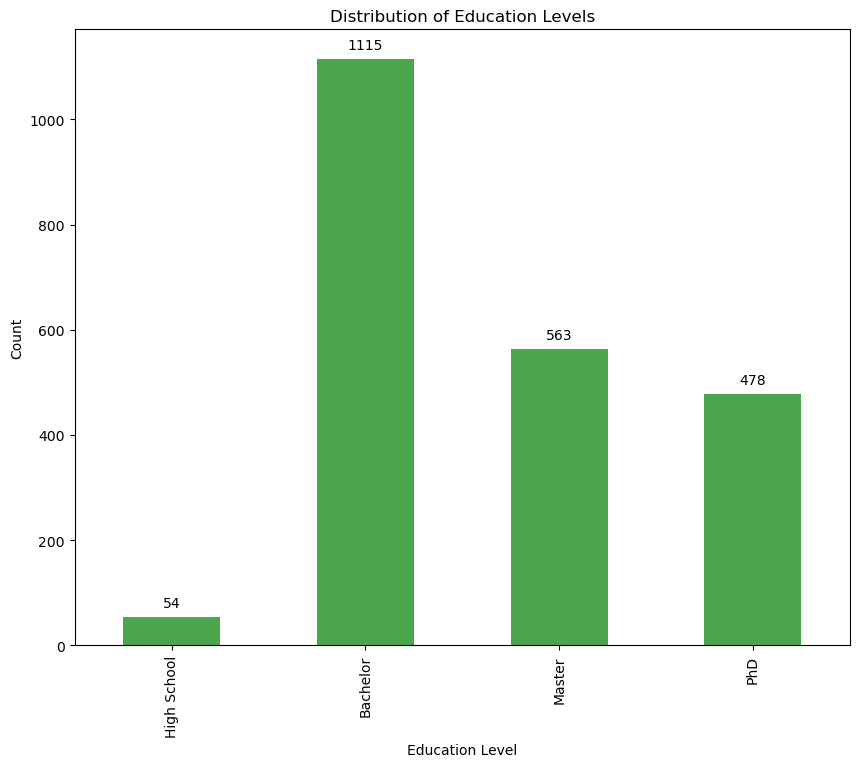

In [34]:
education_order = ['High School', 'Bachelor', 'Master', 'PhD']

plt.figure(figsize=(10, 8))
educationplt = df['Education'].value_counts()[education_order].plot(kind='bar', color='green', alpha=0.7)
plt.title('Distribution of Education Levels')
plt.xlabel('Education Level')
plt.ylabel('Count')

for p in educationplt.patches:
    educationplt.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

## 2. Data Processing

This step consists of processing the data and includes the following:

* Properly scale quantitative values (Normalization/Standardization)
* Encoding categorical variables
* Re-check to see if everything was applied correctly

Noramalizing quantitative values:

In [ ]:

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['Age', 'Income', 'Total expenses'] + list(df.filter(regex='AcceptedCmp').columns)]

# Initialize the MinMaxScaler
scaler = pp.MinMaxScaler()

# Fit and transform the data
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Show the first few rows to verify normalization
print(df.head())

In [25]:
# Perform one-hot encoding for categorical columns
df_encoded = pd.get_dummies(df, columns=['Education', 'Marital_Status'], drop_first=True)

Encoding the categorical variables:

## 3. Exploratory Data Analysis



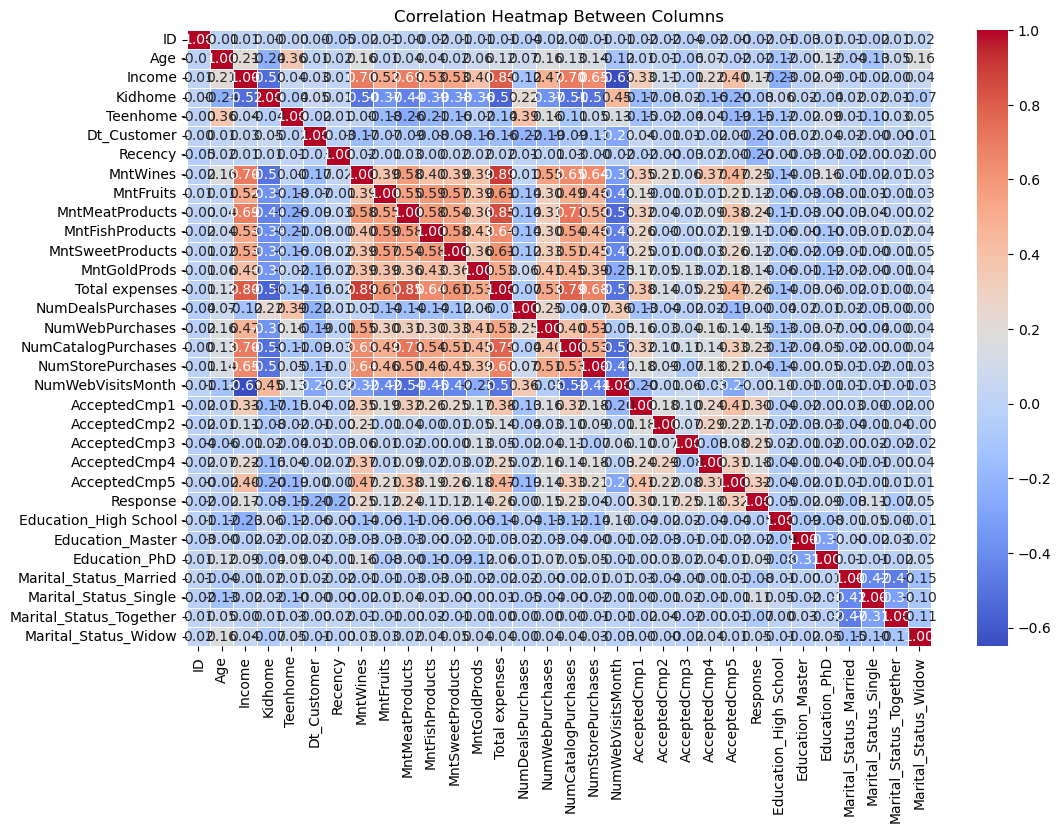

In [30]:
corr_matrix = df_encoded.corr()

# Generate the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap Between Columns')
plt.show()

considerations, focus on income and kidhome
people who visit the website more tend to spend less probably due to being more connected and look for better prices.

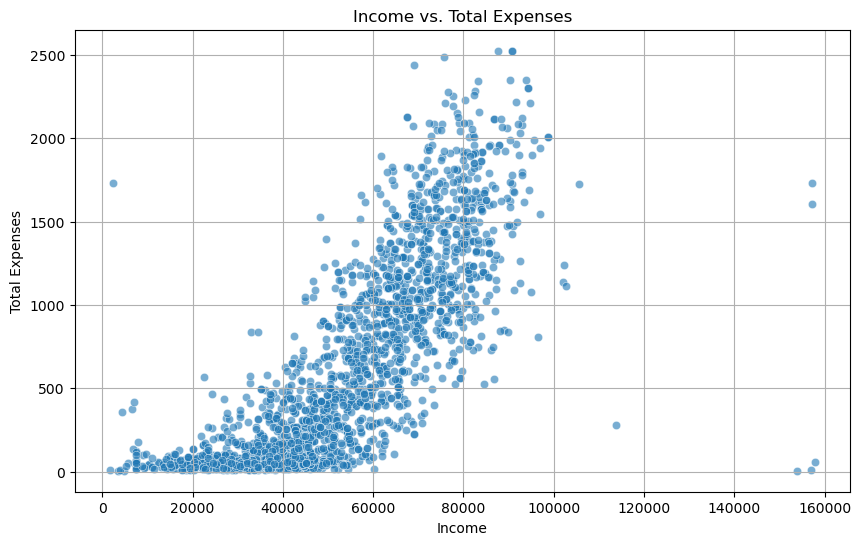

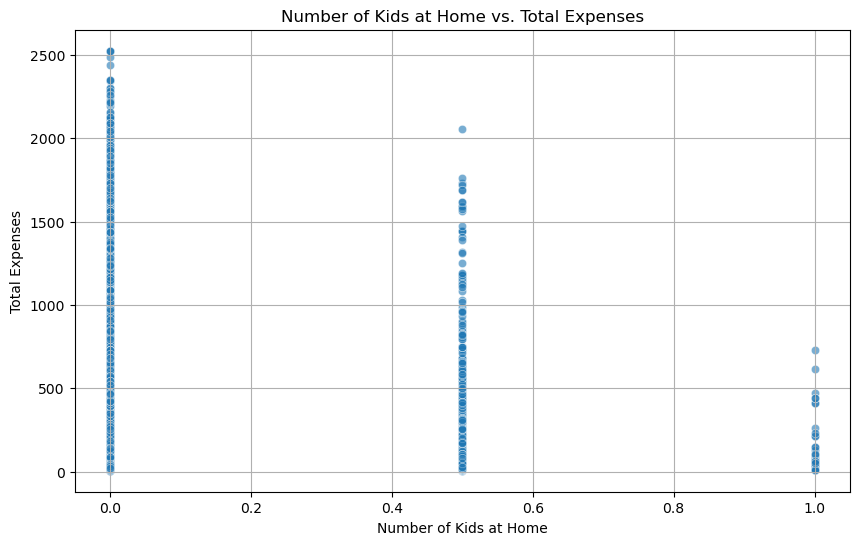

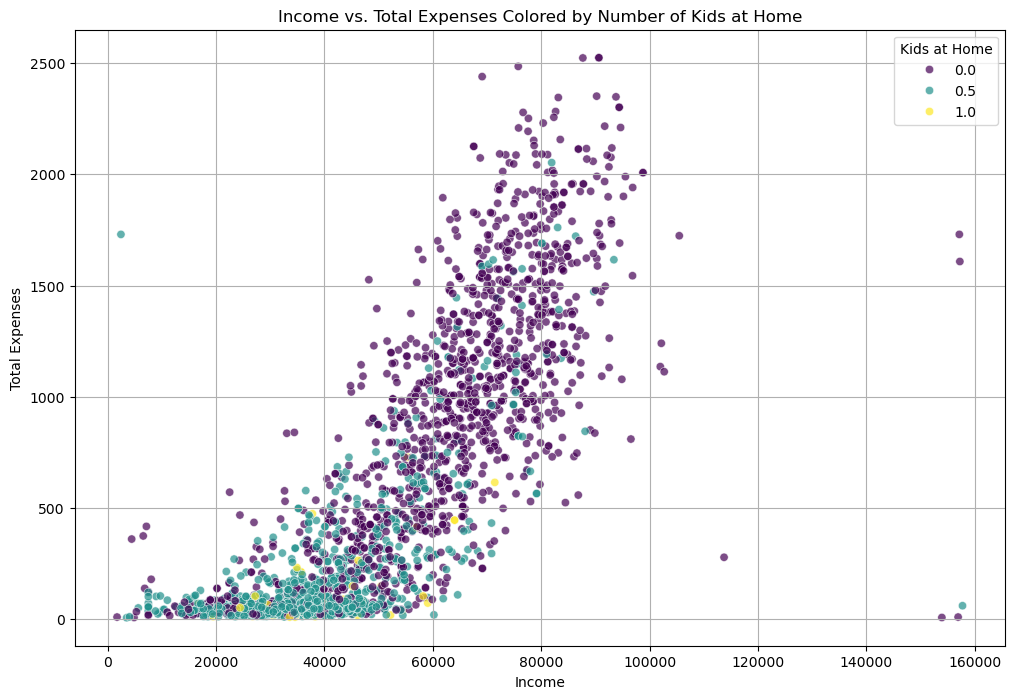

In [36]:
# Ensure the relevant columns are available and correct
# 'Total expenses' might need to be computed if not already done
if 'Total expenses' not in df.columns:
    expense_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
    df['Total expenses'] = df[expense_columns].sum(axis=1)

# Scatter Plot: Income vs. Total Expenses
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Income', y='Total expenses', alpha=0.6)
plt.title('Income vs. Total Expenses')
plt.xlabel('Income')
plt.ylabel('Total Expenses')
plt.grid(True)
plt.show()

# Scatter Plot: Kidhome vs. Total Expenses
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Kidhome', y='Total expenses', alpha=0.6)
plt.title('Number of Kids at Home vs. Total Expenses')
plt.xlabel('Number of Kids at Home')
plt.ylabel('Total Expenses')
plt.grid(True)
plt.show()

# Income vs. Expenses colored by presence of Kids at Home
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Income', y='Total expenses', hue='Kidhome', palette='viridis', alpha=0.7)
plt.title('Income vs. Total Expenses Colored by Number of Kids at Home')
plt.xlabel('Income')
plt.ylabel('Total Expenses')
plt.legend(title='Kids at Home')
plt.grid(True)
plt.show()
print('It is possible to see that customers with no kids at home are more likely to spend more than customers with kids at home. \n The fact of being 1 or 2 kids does not seem to make that much of a difference in the spending habbits, just the fact that the customer has a kid')

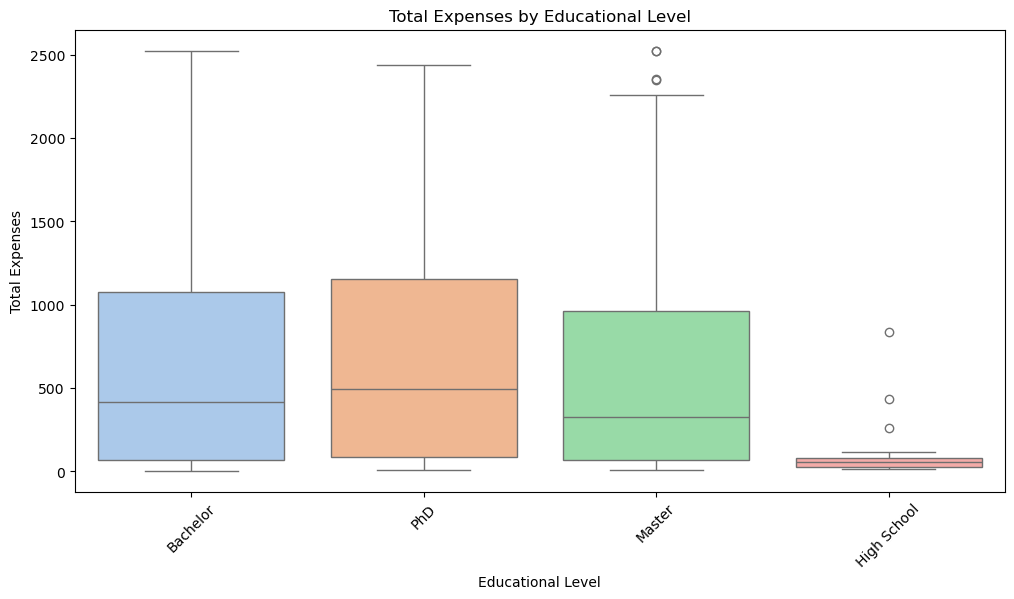

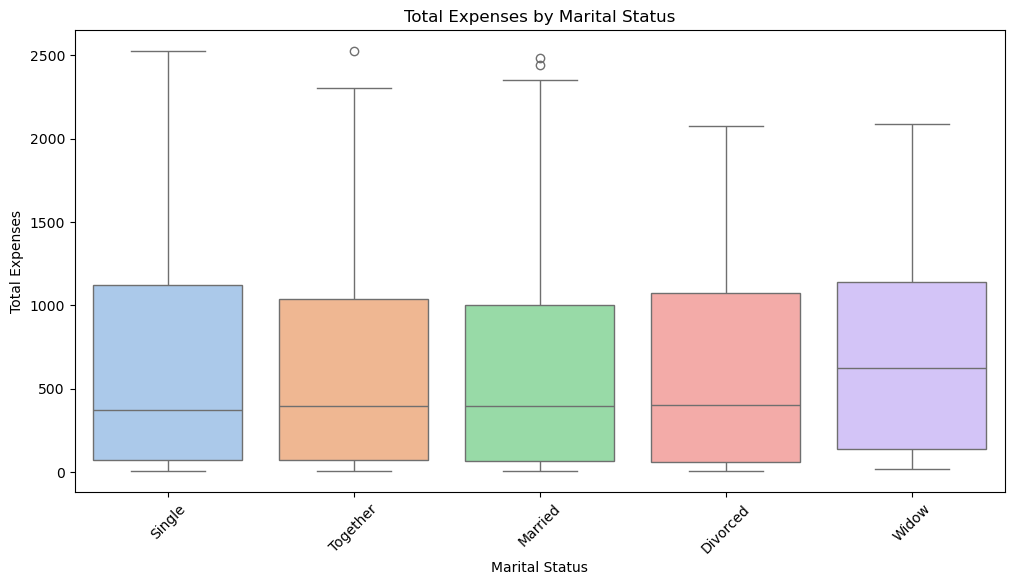

In [37]:
# Boxplot for Total Expenses by Education
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Education', y='Total expenses', palette='pastel')
plt.title('Total Expenses by Educational Level')
plt.xlabel('Educational Level')
plt.ylabel('Total Expenses')
plt.xticks(rotation=45)
plt.show()

# Boxplot for Total Expenses by Marital Status
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Marital_Status', y='Total expenses', palette='pastel')
plt.title('Total Expenses by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Total Expenses')
plt.xticks(rotation=45)
plt.show()

<Figure size 1400x800 with 0 Axes>

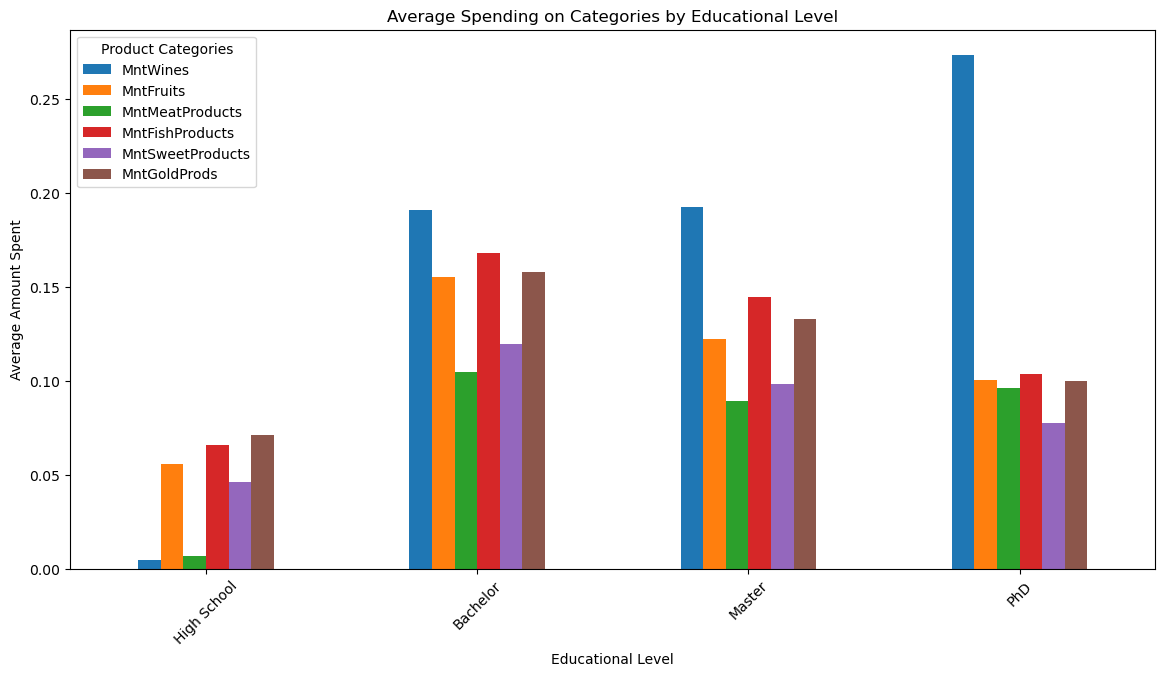

<Figure size 1400x800 with 0 Axes>

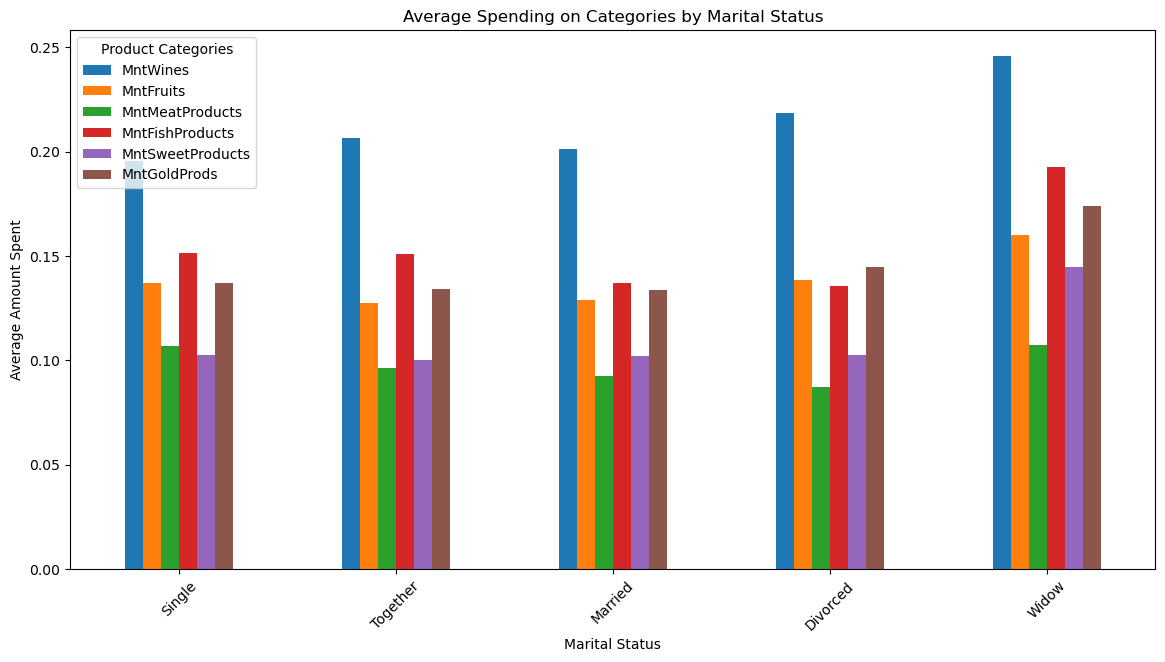

In [39]:
df['Education'] = pd.Categorical(df['Education'], categories=education_order, ordered=True)
df['Marital_Status'] = pd.Categorical(df['Marital_Status'], categories=marital_order, ordered=True)

# Spending Categories
spending_categories = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

# Plotting spending by Education
plt.figure(figsize=(14, 8))
df.groupby('Education')[spending_categories].mean().plot(kind='bar', figsize=(14, 7))
plt.title('Average Spending on Categories by Educational Level')
plt.xlabel('Educational Level')
plt.ylabel('Average Amount Spent')
plt.xticks(rotation=45)
plt.legend(title='Product Categories')
plt.show()

# Plotting spending by Marital Status
plt.figure(figsize=(14, 8))
df.groupby('Marital_Status')[spending_categories].mean().plot(kind='bar', figsize=(14, 7))
plt.title('Average Spending on Categories by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Average Amount Spent')
plt.xticks(rotation=45)
plt.legend(title='Product Categories')
plt.show()

In [40]:
promotion_columns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']

# Sum up all accepted campaigns to see how many each customer accepted
df['TotalAcceptedCmps'] = df[promotion_columns].sum(axis=1)

# Add a column to easily filter anyone who accepted at least one campaign
df['AcceptedAnyCmp'] = df['TotalAcceptedCmps'] > 0

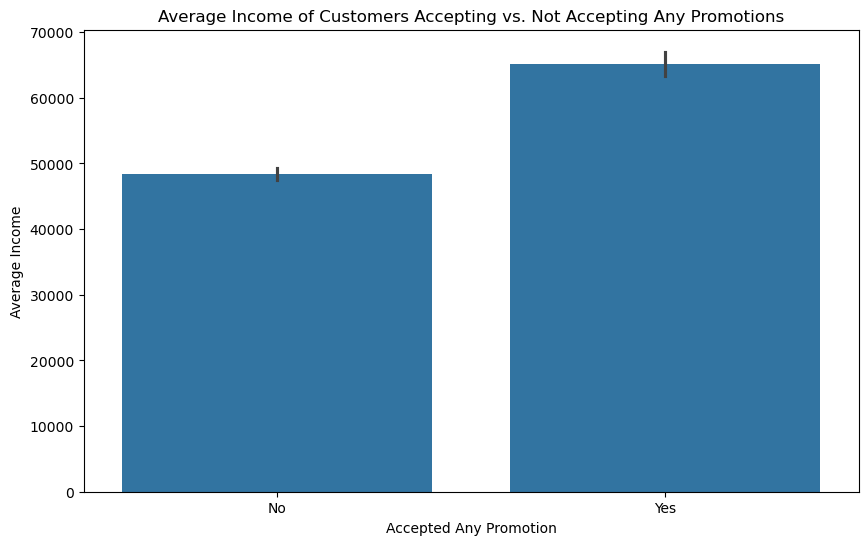

In [41]:
# Plot average income for those who accepted any vs. none
plt.figure(figsize=(10, 6))
sns.barplot(x='AcceptedAnyCmp', y='Income', data=df)
plt.title('Average Income of Customers Accepting vs. Not Accepting Any Promotions')
plt.xlabel('Accepted Any Promotion')
plt.ylabel('Average Income')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

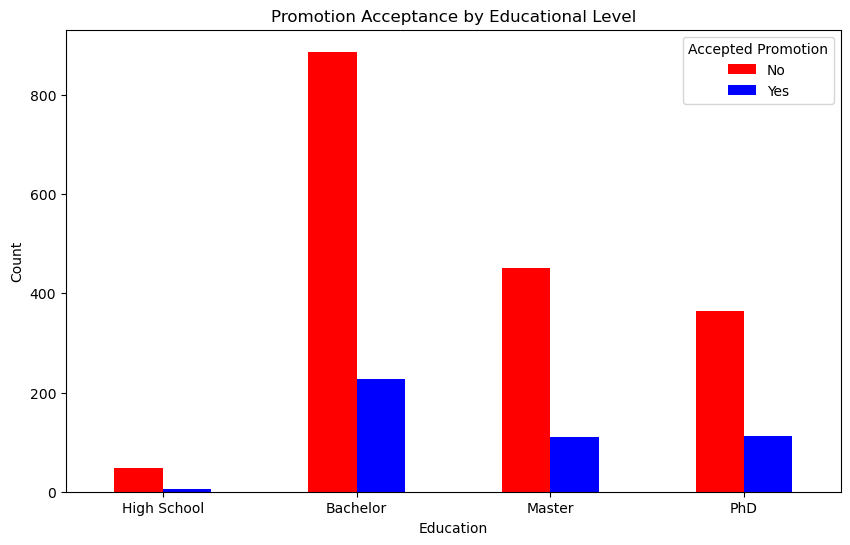

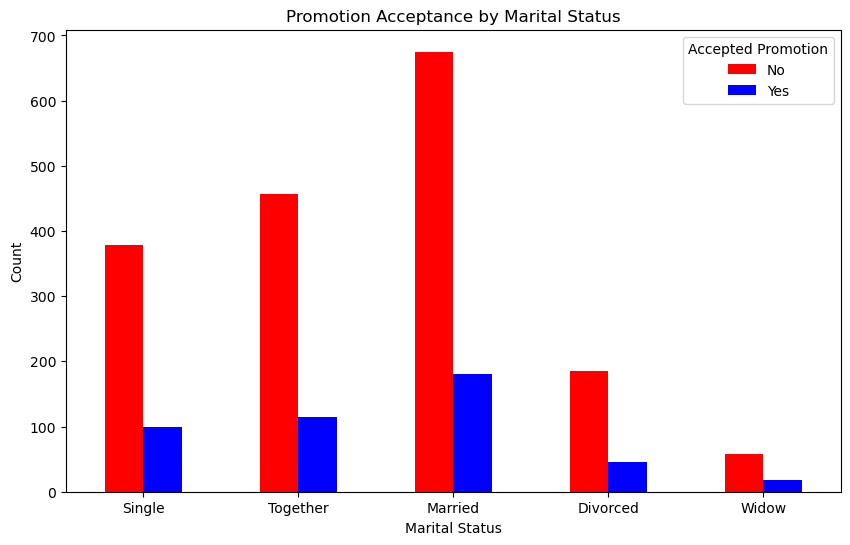

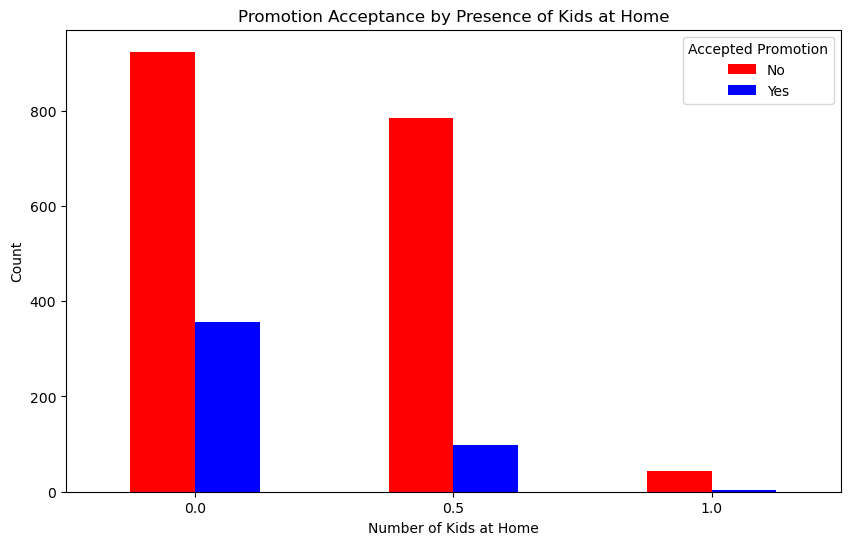

In [43]:
# Crosstabulation for each category
edu_crosstab = pd.crosstab(df['Education'], df['AcceptedAnyCmp'])
marital_crosstab = pd.crosstab(df['Marital_Status'], df['AcceptedAnyCmp'])
kids_crosstab = pd.crosstab(df['Kidhome'], df['AcceptedAnyCmp'])

# Plotting function
def plot_grouped_bar(crosstab, title, xlabel):
    ax = crosstab.plot(kind='bar', color=['red', 'blue'], figsize=(10, 6))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Count')
    ax.legend(title='Accepted Promotion', labels=['No', 'Yes'])
    plt.xticks(rotation=0)
    plt.show()

# Education and promotion acceptance
plot_grouped_bar(edu_crosstab, 'Promotion Acceptance by Educational Level', 'Education')

# Marital status and promotion acceptance
plot_grouped_bar(marital_crosstab, 'Promotion Acceptance by Marital Status', 'Marital Status')

# Kids at home and promotion acceptance
plot_grouped_bar(kids_crosstab, 'Promotion Acceptance by Presence of Kids at Home', 'Number of Kids at Home')

In [44]:
product_sales = {
    'Wines': df['MntWines'].sum(),
    'Fruits': df['MntFruits'].sum(),
    'Meat Products': df['MntMeatProducts'].sum(),
    'Fish Products': df['MntFishProducts'].sum(),
    'Sweet Products': df['MntSweetProducts'].sum(),
    'Gold Products': df['MntGoldProds'].sum()
}

# Total expenses might already be calculated as a sum of all product expenses, if not calculate it
total_expenses = sum(product_sales.values())

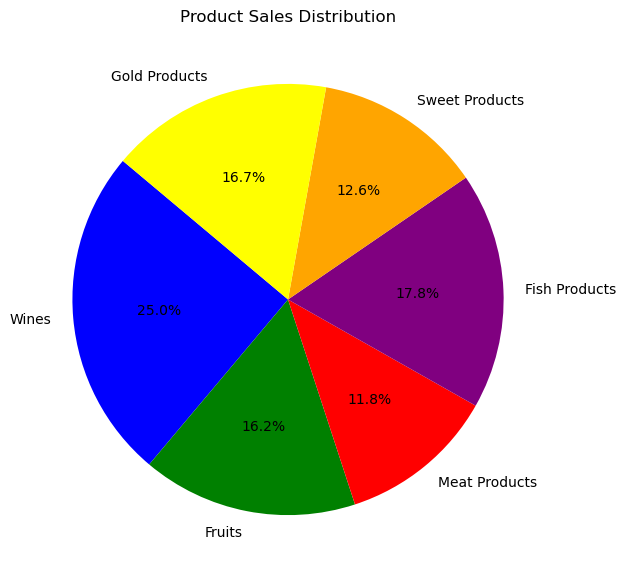

In [65]:
# Labels and sizes for the pie chart from the dictionary
labels = product_sales.keys()
sizes = product_sales.values()
colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow']  # Assign a color to each product

plt.figure(figsize=(10, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Product Sales Distribution')
plt.show()

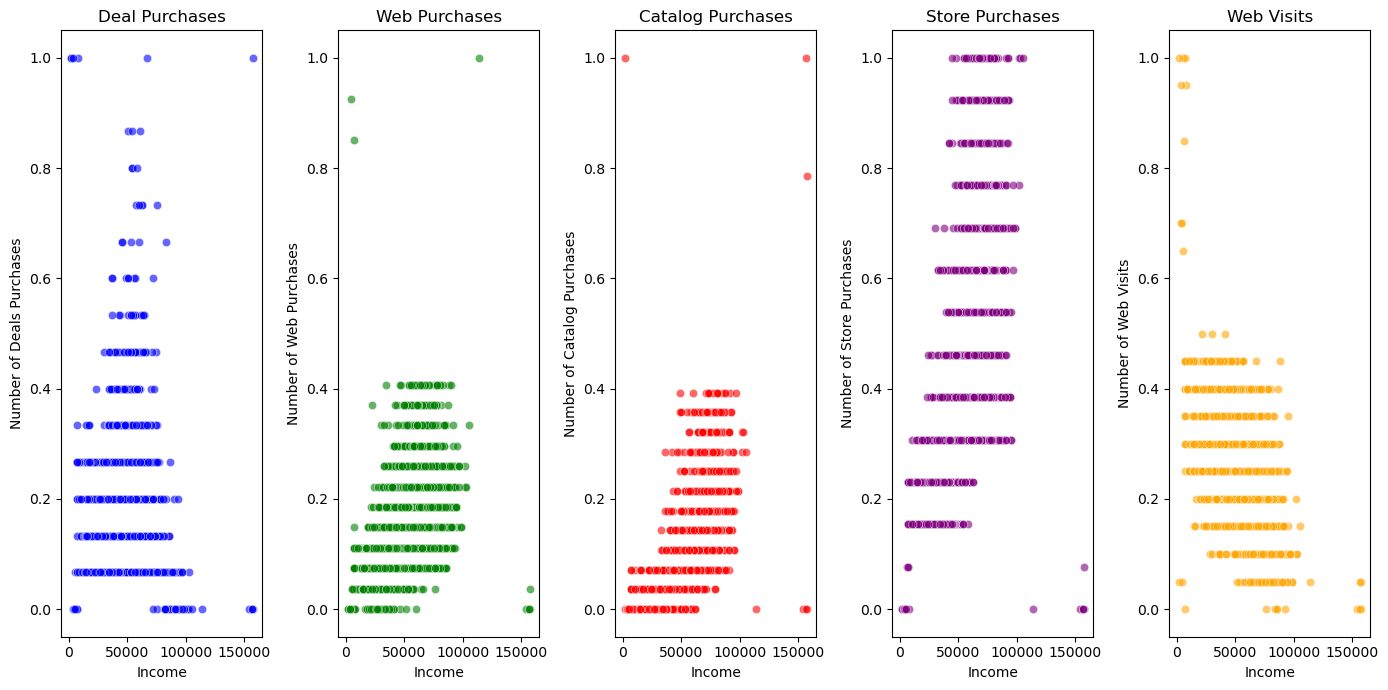

In [54]:
plt.figure(figsize=(14, 7))

# Create a subplot for each type of purchase
plt.subplot(1, 5, 1)
sns.scatterplot(data=df, x='Income', y='NumDealsPurchases', color='blue', alpha=0.6)
plt.title('Deal Purchases')
plt.ylabel('Number of Deals Purchases')

plt.subplot(1, 5, 2)
sns.scatterplot(data=df, x='Income', y='NumWebPurchases', color='green', alpha=0.6)
plt.title('Web Purchases')
plt.ylabel('Number of Web Purchases')

plt.subplot(1, 5, 3)
sns.scatterplot(data=df, x='Income', y='NumCatalogPurchases', color='red', alpha=0.6)
plt.title('Catalog Purchases')
plt.ylabel('Number of Catalog Purchases')

plt.subplot(1, 5, 4)
sns.scatterplot(data=df, x='Income', y='NumStorePurchases', color='purple', alpha=0.6)
plt.title('Store Purchases')
plt.ylabel('Number of Store Purchases')

plt.subplot(1, 5, 5)
sns.scatterplot(data=df, x='Income', y='NumWebVisitsMonth', color='orange', alpha=0.6)
plt.title('Web Visits')
plt.ylabel('Number of Web Visits')

plt.tight_layout()
plt.show()

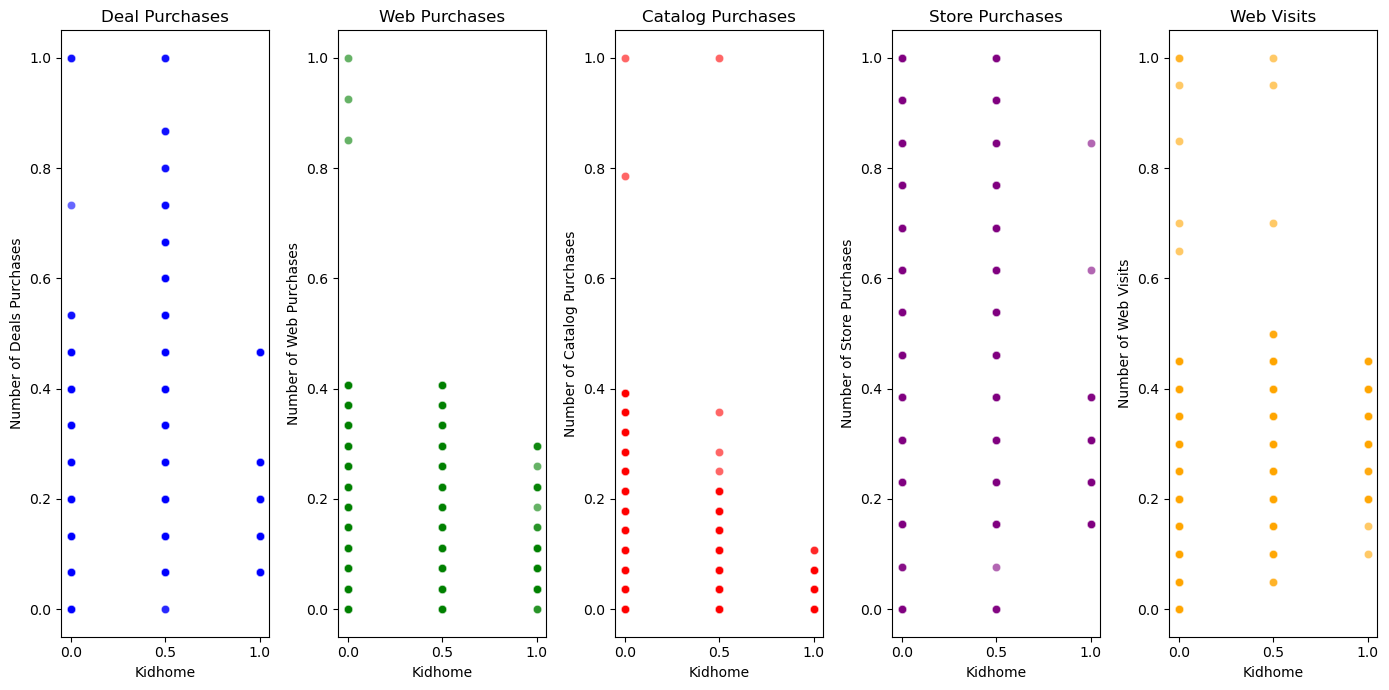

In [55]:
plt.figure(figsize=(14, 7))

# Create a subplot for each type of purchase
plt.subplot(1, 5, 1)
sns.scatterplot(data=df, x='Kidhome', y='NumDealsPurchases', color='blue', alpha=0.6)
plt.title('Deal Purchases')
plt.ylabel('Number of Deals Purchases')

plt.subplot(1, 5, 2)
sns.scatterplot(data=df, x='Kidhome', y='NumWebPurchases', color='green', alpha=0.6)
plt.title('Web Purchases')
plt.ylabel('Number of Web Purchases')

plt.subplot(1, 5, 3)
sns.scatterplot(data=df, x='Kidhome', y='NumCatalogPurchases', color='red', alpha=0.6)
plt.title('Catalog Purchases')
plt.ylabel('Number of Catalog Purchases')

plt.subplot(1, 5, 4)
sns.scatterplot(data=df, x='Kidhome', y='NumStorePurchases', color='purple', alpha=0.6)
plt.title('Store Purchases')
plt.ylabel('Number of Store Purchases')

plt.subplot(1, 5, 5)
sns.scatterplot(data=df, x='Kidhome', y='NumWebVisitsMonth', color='orange', alpha=0.6)
plt.title('Web Visits')
plt.ylabel('Number of Web Visits')

plt.tight_layout()
plt.show()

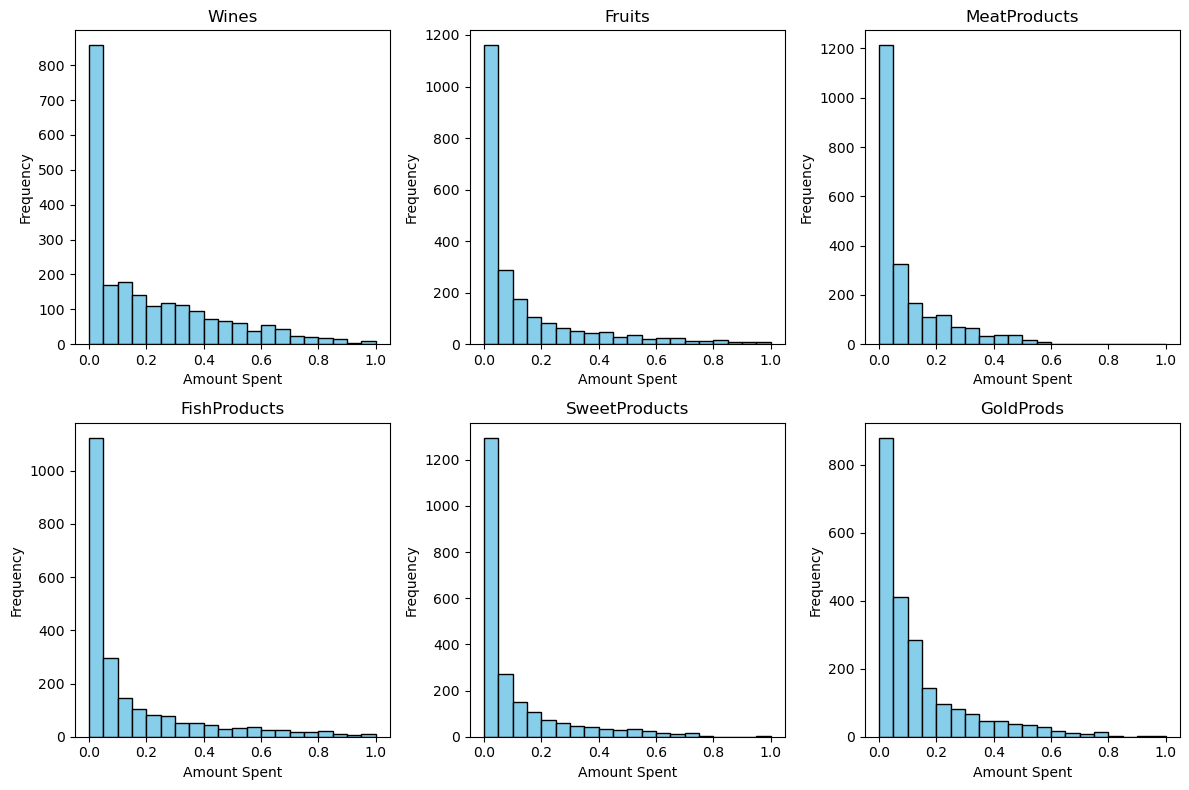

In [59]:
product_categories = [
    'MntWines', 'MntFruits', 'MntMeatProducts',
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'
]

# Set up the plotting area
plt.figure(figsize=(12, 8))  # Overall figure size

# Loop through the product categories and create a histogram for each
for i, category in enumerate(product_categories):
    plt.subplot(2, 3, i + 1)  # Subplots in a 2 rows x 3 columns grid
    plt.hist(df[category], bins=20, color='skyblue', edgecolor='black')  # You can adjust bins as needed
    plt.title(category.replace('Mnt', ''))
    plt.xlabel('Amount Spent')
    plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

In [66]:
# Calculate the total number of purchases for each customer
# Assuming df has columns like 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases'
df['TotalPurchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']

# Define frequent customers as those in the top 25% of total purchases made
threshold = df['TotalPurchases'].quantile(0.75)
df['CustomerType'] = df['TotalPurchases'].apply(lambda x: 'Frequent' if x >= threshold else 'Infrequent')

# View the first few rows to verify
print(df[['TotalPurchases', 'CustomerType']].head())

   TotalPurchases CustomerType
0        0.961131   Infrequent
1        0.226597   Infrequent
2        1.136956     Frequent
3        0.381766   Infrequent
4        0.753867   Infrequent


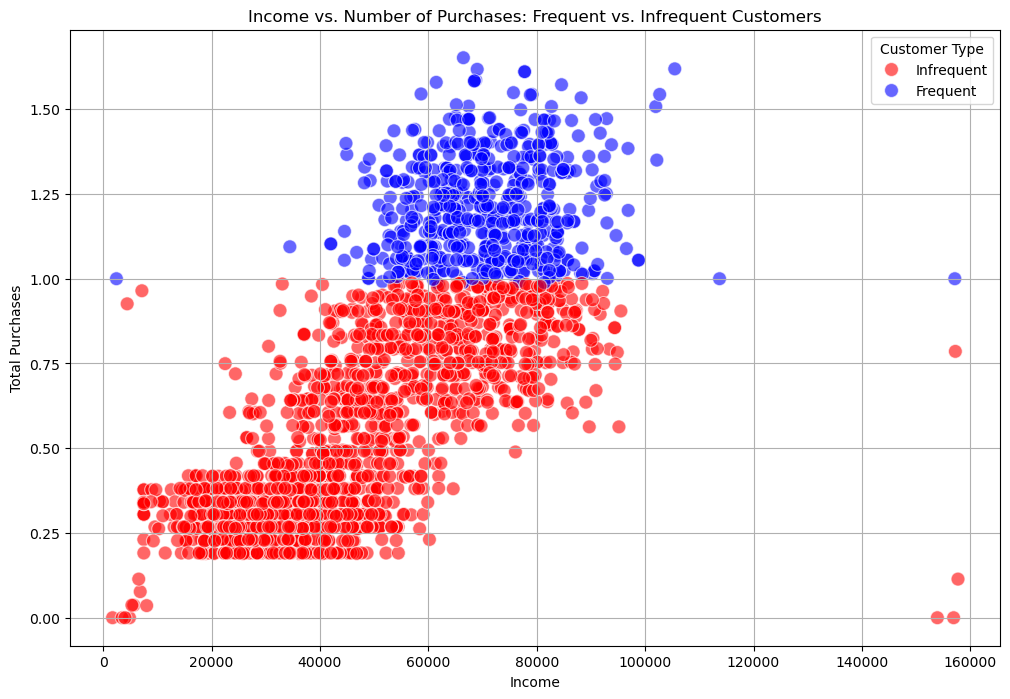

In [70]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Income', y='TotalPurchases', hue='CustomerType', style='CustomerType', palette={'Frequent': 'blue', 'Infrequent': 'red'}, markers='o' , s=100, alpha=0.6)

plt.title('Income vs. Number of Purchases: Frequent vs. Infrequent Customers')
plt.xlabel('Income')
plt.ylabel('Total Purchases')
plt.legend(title='Customer Type')
plt.grid(True)
plt.show()